In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
%matplotlib inline

Given what we've learned so far, let's tackle [this Kaggle competition](https://www.kaggle.com/c/titanic-gettingStarted).

In [3]:
train = pd.read_csv("titanic/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [4]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

We've got many features here:

* The passenger class (first, second, or third)
* The sex of the passenger
* The age of the passenger (some are missing -- we'll have to figure out what to do about that)
* The number of siblings and spouses the passenger had on board (SubSp)
* The number of parents and children the passenger had on board (Parch)
* The amount the passenger paid for their ticket
* Where the passenger embarked from

The name and cabin are immaterial. The cabin might help, if we had a map of the ship and
there weren't so many null values for cabin.

_Using your intuition, what feature vectors might be important?_

## Finding patterns in the data

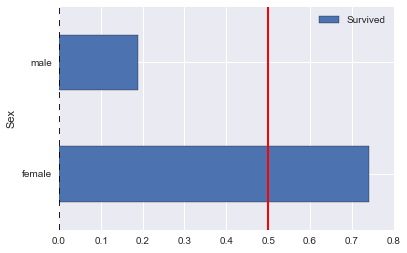

In [5]:
pd.pivot_table(train, index=["Sex"], values=["Survived"]).plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')

There's a marked difference in survival rates between men and women. Let's go ahead and enter the competition just using that as our metric.

In [6]:
test = pd.read_csv("titanic/test.csv")
test["Survived"] = 0
test.loc[test["Sex"] == "female", "Survived"] = 1
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/gendermodel.csv", index=False)

Does age seem to matter?

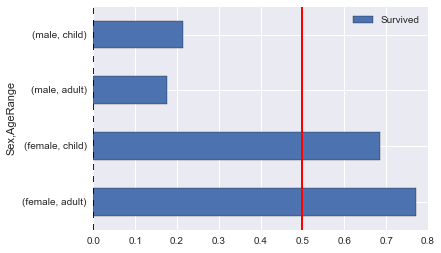

In [156]:
train["AgeRange"] = train["Age"].map(lambda x: "adult" if x >= 18 else "child")
pd.pivot_table(train, index=["Sex", "AgeRange"], values=["Survived"]).plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')

How about passenger class?

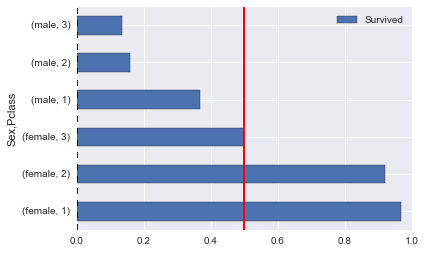

In [157]:
pd.pivot_table(train, index=["Sex", "Pclass"], values=["Survived"]).plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')

Passenger class definitely mattered. The survival rate for women in 3rd class is under 50%.

What if we added in the price of the ticket? This will work best with discrete values, so we break it into tickets less than \$10, tickets between \$10 and \$20, tickets between \$20 and \$30, and tickets over \$30.

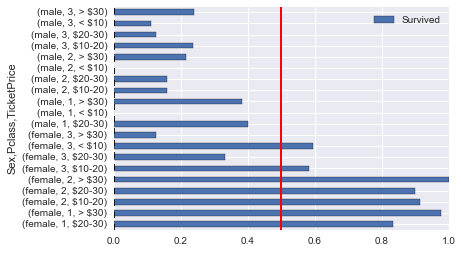

In [158]:
def ticket_price(fare):
    if fare < 10:
        return "< $10"
    elif fare < 20:
        return "$10-20"
    elif fare < 30:
        return "$20-30"
    else:
        return "> $30"
    
train["TicketPrice"] = train["Fare"].map(ticket_price)
pd.pivot_table(train, index=["Sex", "Pclass", "TicketPrice"], values=["Survived"]) \
    .plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')

Ok, this is now meaningful. The groups with survival rate > 50% are:

* Women in 1st and 2nd class.
* Women in 3rd class that paid $20 or less.

In [7]:
test = pd.read_csv("titanic/test.csv")

test["Survived"] = 0
test.loc[test["Sex"] == "female", "Survived"] = 1
test.loc[(test["Pclass"] == 3) & (test["Fare"] > 20), "Survived"] = 0
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/genderclassmodel.csv", index=False)

## Cleaning data

To do any better than this, we'll need to clean up our data. We'll need everything to be numerical so we can use them as real features.

Let's turn all the strings we might use into numbers.

In [160]:
train['Gender'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [161]:
# Get the median age of passengers by sex and class, for filling in missing ages.
median_ages = np.zeros((2,3))

for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = train[(train['Gender'] == i) & \
                                 (train['Pclass'] == j+1)]['Age'].dropna().median()

median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [162]:
# Fill in the median age for persons with missing ages.
for i in range(0, 2):
    for j in range(0, 3):
        train.loc[(train.Age.isnull()) & (train.Gender == i) & (train.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

train[ train['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head()

Gender  Pclass  Age  AgeFill
5        1       3  NaN     25.0
17       1       2  NaN     30.0
19       0       3  NaN     21.5
26       1       3  NaN     25.0
28       0       3  NaN     21.5

In [163]:
# Remember which ages were null.
train['AgeIsNull'] = pd.isnull(train.Age).astype(int)

In [164]:
def calc_median_ages(df):
    median_ages = np.zeros((2,3))

    for i in range(0, 2):
        for j in range(0, 3):
            median_ages[i,j] = df[(df['Gender'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna().median()
            
    return median_ages


def guess_ages(df, median_ages=None):
    if median_ages is None:
        median_ages = calc_median_ages(df)
        
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[(df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                    'Age'] = median_ages[i,j]
            
    df['GuessedAge'] = pd.isnull(df.Age).astype(int)
    return df

def clean(df, median_ages=None):
    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df = guess_ages(df, median_ages)
    df = df.drop(['Ticket', 'Cabin', 'Sex'], axis=1)
    
    return df

In [165]:
train = pd.read_csv("titanic/train.csv")
train = clean(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Gender         891 non-null int64
GuessedAge     891 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 83.5+ KB


In [166]:
train.dtypes[train.dtypes.map(lambda x: x=='object')]

Name        object
Embarked    object
dtype: object

We might want to get the port the passenger embarked from as a number. Do this as an exercise.

We also might want to use regular expressions on the names to look for titles like "Dr" and "Rev".

We may want to add new features, like total family size.

In [167]:
median_ages = calc_median_ages(train)
test = pd.read_csv("titanic/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [168]:
test = clean(test, median_ages)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Gender         418 non-null int64
GuessedAge     418 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 35.9+ KB
